In [1]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
import activeLearningCortical as ALC
%load_ext autoreload
%autoreload 2

#NEEDED FOR LASSO
from sklearn.preprocessing import StandardScaler
from pyglmnet import GLM

# Load Ground Truth

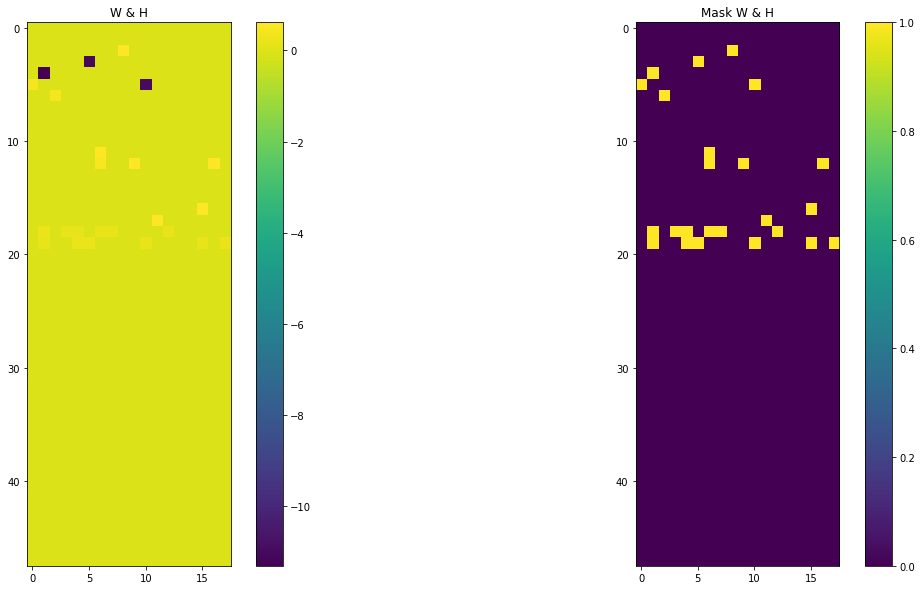

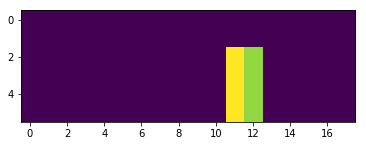

(48, 18)


In [2]:
# LOAD 1 CLUSTER NETWORK
W_kernel, H_kernel, b_kernel =  ALC.utils.load_networks('SW1CL')

W_adj = np.sum(W_kernel,axis = 0)
H_adj = np.sum(H_kernel,axis = 0)


W_GT = np.concatenate([W_adj,H_adj],axis = 0)
M_GT = np.array(W_GT)
M_GT[M_GT != 0] = 1


plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.title('W & H')
plt.imshow(W_GT)
plt.colorbar()

plt.subplot(1,2,2)
plt.title('Mask W & H')
plt.imshow(M_GT)
plt.colorbar()
plt.show()

plt.imshow(W_kernel[:,:,6])
plt.show()

print(M_GT.shape)

# Parameters for Model Inference

In [3]:
D_c_u = -2
D_c_l = -5
D_s_u = -2
D_s_l = -5
k = 1
kappa = 10
sensitivity_th = 0.2
samples_array = np.array([2000,4000,8000,12000,16000])
n_realizations = np.arange(10)
seeds_array = np.array(n_realizations)

gamma_array = np.array([0.001])
approx_gamma = 10*gamma_array

nu_array = np.array([1,0.9,0.7,0.5])
n_splits_array=np.array([1,5,5,5])


PREC_BIC = np.zeros([n_realizations.shape[0],gamma_array.shape[0],samples_array.shape[0],nu_array.shape[0]])
REC_BIC = np.zeros([n_realizations.shape[0],gamma_array.shape[0],samples_array.shape[0],nu_array.shape[0]])
F1_BIC = np.zeros([n_realizations.shape[0],gamma_array.shape[0],samples_array.shape[0],nu_array.shape[0]])
W_dic = {}
F_dic = {}
pval_dic = {}
spikes_dic = {}
stimuli_dic = {}




##Choose where to save data

In [4]:
file_uid_save = 'our_spikes_database/paper_CL1_VarSel_git.pkl'
print(n_realizations)

[0 1 2 3 4 5 6 7 8 9]


# Run Model Inference BIC

In [4]:
for nr in (n_realizations):
    
    #Load Data
    print(' REALIZATION ::: ', nr)
    
    #SIMULATE REALIZATION#
    dframes_stimuli = 4
    n_samples_simulate = np.max(samples_array)+100
    
    uniform_probability = np.ones(H_adj.shape[0])
    uniform_probability /= uniform_probability.sum()
    
    np.seed = seeds_array[nr]
    stimuli_samples = ALC.getSampledStimuli(n_samples_simulate, dframes_stimuli, uniform_probability)
    
    np.seed = seeds_array[nr]
    spikes_simul, stimuli_simul = ALC.generate_spikes(W_kernel,H_kernel, b_kernel,
                                   stimuli_samples, kappa=kappa,
                                   expected=False) #if expected true you get the expected spiking rates

    spikes_dic[nr] = spikes_simul
    stimuli_dic[nr] = stimuli_simul
#     print(spikes_simul.shape, stimuli_simul.shape)
    
    i=0
    for sample_i in samples_array:
        print(' Samples ::: ', sample_i)
        #Get sample_i samples
        Xd = spikes_simul[0:sample_i, :]
        Id = stimuli_simul[0:sample_i, :]
        
        j = 0
        for gamma in gamma_array:
            print(' Gamma ::: ', gamma)
        
            ii = 0
            
            for nu in nu_array:
                n_splits = n_splits_array[ii]
                print(' Nu ::: ', nu , 'Splits ::' , n_splits)
                
                #Build new model
                model = ALC.ClassModel(D_c_l=D_c_l, D_c_u=D_c_u, D_s_l=D_s_l, D_s_u=D_s_u, k=k,kappa=kappa, X=Xd, I=Id, gamma=gamma,approx_gamma= approx_gamma,nu=nu, n_splits=n_splits,sensitivity_th=sensitivity_th,logfile='our_spikes_database/CL1_gamma_k01.txt',checkpoint='our_spikes_database/CL1_gamma_k01_checkpoint')
                model.seed = seeds_array[nr]
                model.updateModel()
            
                #Save estimated parameters + fishers
                W_est = np.concatenate([model.W,model.H,model.b],axis = 0)
                W_dic[nr,i,j,ii] = W_est
            
                F_est = np.concatenate([model.W_fisher,model.H_fisher,model.b_fisher],axis = 0)
                F_dic[nr,i,j,ii] = F_est
            
                pval_est = np.concatenate([model.W_pval,model.H_pval,model.b_pval],axis = 0)
                pval_dic[nr,i,j,ii] = pval_est
            
        
                #GET STATS AND SAVE THEM
                M = np.array(W_est[:-1,:])
#                 print(M.shape, M_GT.shape)
                M[M != 0] = 1
                WF = 2*M + M_GT
            
                TP = (np.sum(WF[:,:] == 3))
                FP = (np.sum(WF[:,:] == 2))
                FN = (np.sum(WF[:,:] == 1))
        
                REC = TP/np.maximum((TP+FN),1e-20)
                PREC = TP/np.maximum((TP+FP),1e-20)
                F1 = 2*REC*PREC/np.maximum((REC + PREC),1e-20)
        
                print('############################ RES')
                print('nr : ' + str(nr) + '; samples : '+ str(sample_i) + ' ; gamma : ' + str(gamma) + ' ; nu : ' + str(nu) )
                print('Prec: ' + str(PREC) + ' ; Rec : '+ str(REC) + ' ; F1 : ' + str(F1))
                print('############################ END')
            
                PREC_BIC[nr,j,i,ii] = PREC
                REC_BIC[nr,j,i,ii] = REC
                F1_BIC[nr,j,i,ii] = F1
                ii += 1
                
                save_data = {}
                save_data['W_dic'] = W_dic
                save_data['F_dic'] = F_dic
                save_data['pval_dic'] = pval_dic
                save_data['PREC_BIC'] = PREC_BIC
                save_data['REC_BIC'] = REC_BIC
                save_data['F1_BIC'] = F1_BIC
                save_data['samples_array'] = samples_array
                save_data['gamma_array'] = gamma_array
                save_data['nu_array'] = nu_array
                save_data['spikes_dic'] = spikes_dic
                save_data['stimuli_dic'] = stimuli_dic

                with open(file_uid_save, 'wb') as f:
                    pickle.dump(save_data, f)
            j += 1
            
        i += 1
        

        




 REALIZATION :::  0
 Samples :::  2000
 Gamma :::  0.001
 Nu :::  1.0 Splits :: 1
############################ RES
nr : 0; samples : 2000 ; gamma : 0.001 ; nu : 1.0
Prec: 1.0 ; Rec : 0.20833333333333334 ; F1 : 0.3448275862068966
############################ END
 Nu :::  0.9 Splits :: 5
############################ RES
nr : 0; samples : 2000 ; gamma : 0.001 ; nu : 0.9
Prec: 1.0 ; Rec : 0.20833333333333334 ; F1 : 0.3448275862068966
############################ END
 Nu :::  0.7 Splits :: 5
############################ RES
nr : 0; samples : 2000 ; gamma : 0.001 ; nu : 0.7
Prec: 1.0 ; Rec : 0.20833333333333334 ; F1 : 0.3448275862068966
############################ END
 Nu :::  0.5 Splits :: 5
############################ RES
nr : 0; samples : 2000 ; gamma : 0.001 ; nu : 0.5
Prec: 1.0 ; Rec : 0.16666666666666666 ; F1 : 0.2857142857142857
############################ END
 Samples :::  4000
 Gamma :::  0.001
 Nu :::  1.0 Splits :: 1
############################ RES
nr : 0; samples : 4000 ; gam

############################ RES
nr : 1; samples : 16000 ; gamma : 0.001 ; nu : 0.7
Prec: 1.0 ; Rec : 1.0 ; F1 : 1.0
############################ END
 Nu :::  0.5 Splits :: 5
############################ RES
nr : 1; samples : 16000 ; gamma : 0.001 ; nu : 0.5
Prec: 0.96 ; Rec : 1.0 ; F1 : 0.9795918367346939
############################ END
 REALIZATION :::  2
 Samples :::  2000
 Gamma :::  0.001
 Nu :::  1.0 Splits :: 1
############################ RES
nr : 2; samples : 2000 ; gamma : 0.001 ; nu : 1.0
Prec: 1.0 ; Rec : 0.125 ; F1 : 0.2222222222222222
############################ END
 Nu :::  0.9 Splits :: 5
############################ RES
nr : 2; samples : 2000 ; gamma : 0.001 ; nu : 0.9
Prec: 1.0 ; Rec : 0.125 ; F1 : 0.2222222222222222
############################ END
 Nu :::  0.7 Splits :: 5
############################ RES
nr : 2; samples : 2000 ; gamma : 0.001 ; nu : 0.7
Prec: 1.0 ; Rec : 0.125 ; F1 : 0.2222222222222222
############################ END
 Nu :::  0.5 Splits :: 5
####

############################ RES
nr : 3; samples : 16000 ; gamma : 0.001 ; nu : 0.7
Prec: 1.0 ; Rec : 1.0 ; F1 : 1.0
############################ END
 Nu :::  0.5 Splits :: 5
############################ RES
nr : 3; samples : 16000 ; gamma : 0.001 ; nu : 0.5
Prec: 1.0 ; Rec : 1.0 ; F1 : 1.0
############################ END
 REALIZATION :::  4
 Samples :::  2000
 Gamma :::  0.001
 Nu :::  1.0 Splits :: 1
############################ RES
nr : 4; samples : 2000 ; gamma : 0.001 ; nu : 1.0
Prec: 1.0 ; Rec : 0.125 ; F1 : 0.2222222222222222
############################ END
 Nu :::  0.9 Splits :: 5
############################ RES
nr : 4; samples : 2000 ; gamma : 0.001 ; nu : 0.9
Prec: 1.0 ; Rec : 0.125 ; F1 : 0.2222222222222222
############################ END
 Nu :::  0.7 Splits :: 5
############################ RES
nr : 4; samples : 2000 ; gamma : 0.001 ; nu : 0.7
Prec: 1.0 ; Rec : 0.125 ; F1 : 0.2222222222222222
############################ END
 Nu :::  0.5 Splits :: 5
####################

############################ RES
nr : 5; samples : 16000 ; gamma : 0.001 ; nu : 0.5
Prec: 1.0 ; Rec : 1.0 ; F1 : 1.0
############################ END
 REALIZATION :::  6
 Samples :::  2000
 Gamma :::  0.001
 Nu :::  1.0 Splits :: 1
############################ RES
nr : 6; samples : 2000 ; gamma : 0.001 ; nu : 1.0
Prec: 1.0 ; Rec : 0.2916666666666667 ; F1 : 0.45161290322580644
############################ END
 Nu :::  0.9 Splits :: 5
############################ RES
nr : 6; samples : 2000 ; gamma : 0.001 ; nu : 0.9
Prec: 1.0 ; Rec : 0.2916666666666667 ; F1 : 0.45161290322580644
############################ END
 Nu :::  0.7 Splits :: 5
############################ RES
nr : 6; samples : 2000 ; gamma : 0.001 ; nu : 0.7
Prec: 0.8571428571428571 ; Rec : 0.25 ; F1 : 0.3870967741935483
############################ END
 Nu :::  0.5 Splits :: 5
############################ RES
nr : 6; samples : 2000 ; gamma : 0.001 ; nu : 0.5
Prec: 1.0 ; Rec : 0.25 ; F1 : 0.4
############################ END
 Sa

############################ RES
nr : 7; samples : 16000 ; gamma : 0.001 ; nu : 0.7
Prec: 0.9230769230769231 ; Rec : 1.0 ; F1 : 0.9600000000000001
############################ END
 Nu :::  0.5 Splits :: 5
############################ RES
nr : 7; samples : 16000 ; gamma : 0.001 ; nu : 0.5
Prec: 0.9230769230769231 ; Rec : 1.0 ; F1 : 0.9600000000000001
############################ END
 REALIZATION :::  8
 Samples :::  2000
 Gamma :::  0.001
 Nu :::  1.0 Splits :: 1
############################ RES
nr : 8; samples : 2000 ; gamma : 0.001 ; nu : 1.0
Prec: 1.0 ; Rec : 0.25 ; F1 : 0.4
############################ END
 Nu :::  0.9 Splits :: 5
############################ RES
nr : 8; samples : 2000 ; gamma : 0.001 ; nu : 0.9
Prec: 1.0 ; Rec : 0.25 ; F1 : 0.4
############################ END
 Nu :::  0.7 Splits :: 5
############################ RES
nr : 8; samples : 2000 ; gamma : 0.001 ; nu : 0.7
Prec: 1.0 ; Rec : 0.20833333333333334 ; F1 : 0.3448275862068966
############################ END
 Nu

############################ RES
nr : 9; samples : 16000 ; gamma : 0.001 ; nu : 0.7
Prec: 1.0 ; Rec : 0.9583333333333334 ; F1 : 0.9787234042553191
############################ END
 Nu :::  0.5 Splits :: 5
############################ RES
nr : 9; samples : 16000 ; gamma : 0.001 ; nu : 0.5
Prec: 1.0 ; Rec : 0.9583333333333334 ; F1 : 0.9787234042553191
############################ END


# Run Model Inference LASSO

In [5]:
reg_lambda = np.array([0.05,0.1,0.2,0.3,0.4,0.5])
PREC_LASSO = np.zeros([n_realizations.shape[0],samples_array.shape[0]])
REC_LASSO = np.zeros([n_realizations.shape[0],samples_array.shape[0]])
F1_LASSO = np.zeros([n_realizations.shape[0],samples_array.shape[0]])
W_LASSO = np.zeros([n_realizations.shape[0],samples_array.shape[0],W_GT.shape[0]+1,W_GT.shape[1]])

In [ ]:
# For each realization
for nr in (n_realizations):
    print('###### REALIZATION ::: ', nr)
    
    #LOAD DATA - SAME REALIZATIONS AS BEFORE#
    with open(file_uid_save, 'rb') as f:
        save_data = pickle.load(f)
    stimuli = save_data['stimuli_dic'][nr]
    spikes = save_data['spikes_dic'][nr]
    
    i = 0 #samples index
    #for each number of samples
    for sample_i in samples_array:
        
        #get data samples
        Xd = spikes[0:sample_i, :]
        Id = stimuli[0:sample_i, :]
        
        #Build model just to get regressors (R_hat)
        modelALC = ALC.ClassModel(D_c_l=D_c_l, D_c_u=D_c_u, D_s_l=D_s_l, D_s_u=D_s_u, k=k,kappa=kappa, X=Xd, I=Id)
        total_cells = modelALC.n_c
        total_inputs = modelALC.n_r + 1

        #Build Model with pyGLM
        model = GLM(distr='softplus', verbose=False, alpha=0.05,
                max_iter=1000, learning_rate=1,
                reg_lambda=0, tol = 1e-10)

        #W obtained with Lasso for each reg_lambda
        W_lasso = np.zeros([reg_lambda.shape[0], total_inputs, total_cells])
    
        #for each neuron
        for c in np.arange(total_cells):
            
            #Neuron spike train
            Xc = modelALC.X[:, c]
            R_hat = modelALC.R_hat
            
            #Scale Regressors
            scaler = StandardScaler().fit(R_hat) 
            R_hat_norm = scaler.transform(R_hat)

            #For each regularization lambda
            for j in np.arange(reg_lambda.shape[0]):
                lasso_lambda = reg_lambda[j]
                model.reg_lambda =lasso_lambda 
                model.fit(R_hat_norm, Xc)
                W_lasso[j,:-1,c] = model.beta_ # Regressors weights
                W_lasso[j,-1:,c] = model.beta0_ # bias
            
#         GET PRECISION AND RECAL FOR EACH REGULARIZATION LAMBDA
        PREC_L = np.zeros([reg_lambda.shape[0]])
        REC_L = np.zeros([reg_lambda.shape[0]])
        F1_L = np.zeros([reg_lambda.shape[0]])
        W_L = np.zeros([reg_lambda.shape[0],W_GT.shape[0]+1,W_GT.shape[1]])

        for j in np.arange(reg_lambda.shape[0]):
            
            M = np.array(W_lasso[j,:,:])
            M[M != 0] = 1
            WF = 2*M[:-1,:] + M_GT
            
            TP = (np.sum(WF[:,:] == 3))
            FP = (np.sum(WF[:,:] == 2))
            FN = (np.sum(WF[:,:] == 1))
        
            REC = TP/np.maximum((TP+FN),1e-20)
            PREC = TP/np.maximum((TP+FP),1e-20)
            F1 = 2*REC*PREC/np.maximum((REC + PREC),1e-20)
            
            print('## SAVING ##')
            print('Samples : ' + str(sample_i) + ' ; Reg_lambda : ' + str(reg_lambda[j]))
            print('PREC, REC, F1')
            print(PREC,REC,F1)
            
            PREC_L[j] = PREC
            REC_L[j] = REC
            F1_L[j] = F1
            W_L[j,:,:] = W_lasso[j,:,:]
        
        ix_best = np.argmax(F1_L)
        F1_LASSO[nr,i] = F1_L[ix_best]
        REC_LASSO[nr,i] = REC_L[ix_best]
        PREC_LASSO[nr,i] = PREC_L[ix_best]
        W_LASSO[nr,i,:,:] = W_L[ix_best,:,:]
        
        
        save_data['W_LASSO'] = W_LASSO
        save_data['PREC_LASSO'] = PREC_LASSO
        save_data['REC_LASSO'] = REC_LASSO
        save_data['F1_LASSO'] = F1_LASSO
        save_data['reg_lambda'] = reg_lambda
        save_data['samples_array'] = samples_array
        
        with open(file_uid_save, 'wb') as f:
            pickle.dump(save_data, f)
    
        i += 1


###### REALIZATION :::  0
## SAVING ##
Samples : 2000 ; Reg_lambda : 0.05
PREC, REC, F1
0.04783599088838269 0.875 0.09071274298056156
## SAVING ##
Samples : 2000 ; Reg_lambda : 0.1
PREC, REC, F1
0.11940298507462686 0.6666666666666666 0.20253164556962025
## SAVING ##
Samples : 2000 ; Reg_lambda : 0.2
PREC, REC, F1
0.5 0.4166666666666667 0.45454545454545453
## SAVING ##
Samples : 2000 ; Reg_lambda : 0.3
PREC, REC, F1
1.0 0.20833333333333334 0.3448275862068966
## SAVING ##
Samples : 2000 ; Reg_lambda : 0.4
PREC, REC, F1
1.0 0.20833333333333334 0.3448275862068966
## SAVING ##
Samples : 2000 ; Reg_lambda : 0.5
PREC, REC, F1
0.0 0.0 0.0
## SAVING ##
Samples : 4000 ; Reg_lambda : 0.05
PREC, REC, F1
0.08333333333333333 1.0 0.15384615384615385
## SAVING ##
Samples : 4000 ; Reg_lambda : 0.1
PREC, REC, F1
0.3442622950819672 0.875 0.4941176470588235
## SAVING ##
Samples : 4000 ; Reg_lambda : 0.2
PREC, REC, F1
0.9166666666666666 0.4583333333333333 0.611111111111111
## SAVING ##
Samples : 4000 ; Reg

## SAVING ##
Samples : 16000 ; Reg_lambda : 0.05
PREC, REC, F1
0.4 1.0 0.5714285714285715
## SAVING ##
Samples : 16000 ; Reg_lambda : 0.1
PREC, REC, F1
0.9565217391304348 0.9166666666666666 0.9361702127659574
## SAVING ##
Samples : 16000 ; Reg_lambda : 0.2
PREC, REC, F1
1.0 0.625 0.7692307692307693
## SAVING ##
Samples : 16000 ; Reg_lambda : 0.3
PREC, REC, F1
1.0 0.2916666666666667 0.45161290322580644
## SAVING ##
Samples : 16000 ; Reg_lambda : 0.4
PREC, REC, F1
0.0 0.0 0.0
## SAVING ##
Samples : 16000 ; Reg_lambda : 0.5
PREC, REC, F1
0.0 0.0 0.0
###### REALIZATION :::  3
## SAVING ##
Samples : 2000 ; Reg_lambda : 0.05
PREC, REC, F1
0.053117782909930716 0.9583333333333334 0.10065645514223195
## SAVING ##
Samples : 2000 ; Reg_lambda : 0.1
PREC, REC, F1
0.13496932515337423 0.9166666666666666 0.23529411764705882
## SAVING ##
Samples : 2000 ; Reg_lambda : 0.2
PREC, REC, F1
0.7142857142857143 0.625 0.6666666666666666
## SAVING ##
Samples : 2000 ; Reg_lambda : 0.3
PREC, REC, F1
0.90909090909

## SAVING ##
Samples : 16000 ; Reg_lambda : 0.05
PREC, REC, F1
0.32 1.0 0.48484848484848486
## SAVING ##
Samples : 16000 ; Reg_lambda : 0.1
PREC, REC, F1
1.0 0.9166666666666666 0.9565217391304348
## SAVING ##
Samples : 16000 ; Reg_lambda : 0.2
PREC, REC, F1
1.0 0.5833333333333334 0.7368421052631579
## SAVING ##
Samples : 16000 ; Reg_lambda : 0.3
PREC, REC, F1
1.0 0.25 0.4
## SAVING ##
Samples : 16000 ; Reg_lambda : 0.4
PREC, REC, F1
0.0 0.0 0.0
## SAVING ##
Samples : 16000 ; Reg_lambda : 0.5
PREC, REC, F1
0.0 0.0 0.0
###### REALIZATION :::  6
## SAVING ##
Samples : 2000 ; Reg_lambda : 0.05
PREC, REC, F1
0.04772727272727273 0.875 0.09051724137931035
## SAVING ##
Samples : 2000 ; Reg_lambda : 0.1
PREC, REC, F1
0.13333333333333333 0.75 0.22641509433962267
## SAVING ##
Samples : 2000 ; Reg_lambda : 0.2
PREC, REC, F1
0.6666666666666666 0.5 0.5714285714285715
## SAVING ##
Samples : 2000 ; Reg_lambda : 0.3
PREC, REC, F1
0.8571428571428571 0.25 0.3870967741935483
## SAVING ##
Samples : 2000 ; 

# Plot Results

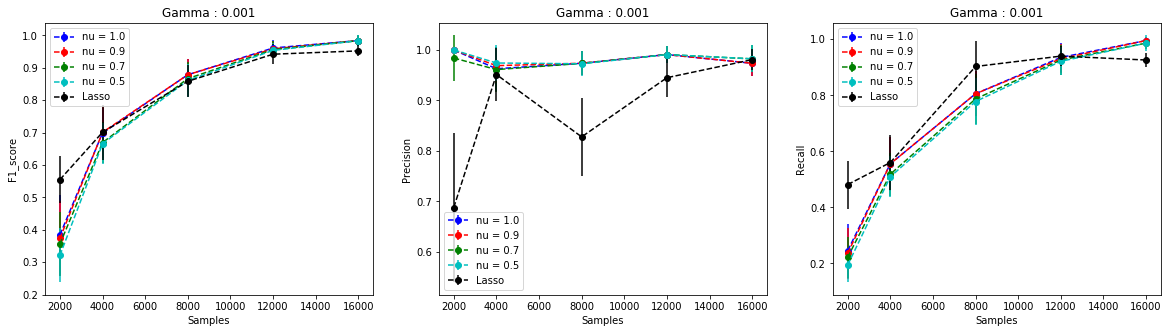

In [7]:
ri = 0
rf = n_realizations[n_realizations.shape[0]-1]

color_array = np.array(['ob','or','og','oc','ok'])
for j in np.arange(gamma_array.shape[0]):
    plt.figure(figsize = (20,5))
    
    plt.subplot(1,3,1)
    for i in np.arange(nu_array.shape[0]):
        plt.errorbar(samples_array,np.mean(F1_BIC[ri:rf,j,:,i],axis = 0),np.std(F1_BIC[ri:rf,j,:,i],axis = 0),linestyle = '--',fmt =  color_array[i],label = 'nu = ' + str(nu_array[i]))
    plt.errorbar(samples_array,np.mean(F1_LASSO[ri:rf,:],axis = 0),np.std(F1_LASSO[ri:rf,:],axis = 0),linestyle = '--',fmt =  color_array[i+1],label = 'Lasso' )
    plt.legend()
    plt.xlabel('Samples')
    plt.ylabel('F1_score')
    plt.title('Gamma : '+ str(gamma_array[j]))

    plt.subplot(1,3,2)
    for i in np.arange(nu_array.shape[0]):
        plt.errorbar(samples_array,np.mean(PREC_BIC[ri:rf,j,:,i],axis = 0),np.std(PREC_BIC[ri:rf,j,:,i],axis = 0),linestyle = '--',fmt =  color_array[i],label = 'nu = ' + str(nu_array[i]))
    plt.errorbar(samples_array,np.mean(PREC_LASSO[ri:rf,:],axis = 0),np.std(PREC_LASSO[ri:rf,:],axis = 0),linestyle = '--',fmt =  color_array[i+1],label = 'Lasso' )
    plt.legend()
    plt.xlabel('Samples')
    plt.ylabel('Precision')
    plt.title('Gamma : '+ str(gamma_array[j]))

    plt.subplot(1,3,3)
    for i in np.arange(nu_array.shape[0]):
        plt.errorbar(samples_array,np.mean(REC_BIC[ri:rf,j,:,i],axis = 0),np.std(REC_BIC[ri:rf,j,:,i],axis = 0),linestyle = '--',fmt =  color_array[i],label = 'nu = ' + str(nu_array[i]))
    plt.errorbar(samples_array,np.mean(REC_LASSO[ri:rf,:],axis = 0),np.std(REC_LASSO[ri:rf,:],axis = 0),linestyle = '--',fmt =  color_array[i+1],label = 'Lasso' )
    plt.legend()
    plt.xlabel('Samples')
    plt.ylabel('Recall')
    plt.title('Gamma : '+ str(gamma_array[j]))

    plt.show()